Данный ноутбук содержит обучение модели Unet для сегментации лёгких и сердца.

Прежде чем запускать данный ноутбук, Вам необходимо выполнить шаги (7), (8), (9), (10) из Preprocessing.ipynb.

'''
Reference
https://www.kaggle.com/code/fx0otd/lung-segmentation-from-chest-x-ray-dataset
'''

# Библиотеки

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
%matplotlib inline
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam

2024-08-27 21:44:25.905519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 21:44:26.764283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Параметры

In [2]:
IMG_SIZE = 224
EPOCHS = 100
BATCH_SIZE = 1
LEARNING_RATE = 0.01
SEED = 42

IMAGE_PATH_CM = os.path.join("Data Segmentation Lung/data/Lung Segmentation/CXR_png")
MASK_PATH_CM = os.path.join("Data Segmentation Lung/data/Lung Segmentation/masks_heart")
IMAGE_PATH_JSRT = os.path.join("JSRT/org_png")
MASK_PATH_JSRT = os.path.join("JSRT/label_cut")
rsna_df = pd.read_csv('Data rsna/lung-segmentation/updated_train.csv')

# Разведка данных

## Шэньчжэнь и Монтгомери

In [3]:
images_CM = os.listdir(IMAGE_PATH_CM)
print('Количество снимков Шэньчжэня и Монтгомери:',len(images_CM))

Количество снимков Шэньчжэня и Монтгомери: 800


In [4]:
masks_CM = os.listdir(MASK_PATH_CM)
print('Количество масок Шэньчжэня и Монтгомери:', len(masks_CM))

Количество масок Шэньчжэня и Монтгомери: 704


In [5]:
check_images = [i for i in images_CM if "CHNCXR" in i]
print("Количество снимков Шэньчжэня:",len(check_images))
print("Количество снимков Монтгомери:",len(images_CM) - len(check_images))

Количество снимков Шэньчжэня: 662
Количество снимков Монтгомери: 138


In [6]:
check_mask_CM = [i for i in masks_CM if "mask" in i]
print("Количество масок Шэньчжэня:",len(check_mask_CM))
print("Количество масок Монтгомери:",len(masks_CM) - len(check_mask_CM))

Количество масок Шэньчжэня: 566
Количество масок Монтгомери: 138


## JSRT

In [7]:
images_JSRT = os.listdir(IMAGE_PATH_JSRT)
print('Количество снимков JSRT:',len(images_JSRT))

Количество снимков JSRT: 247


In [8]:
masks_JSRT = os.listdir(MASK_PATH_JSRT)
print('Количество масок:', len(masks_JSRT))

Количество масок: 247


In [9]:
check_mask_JSRT = [i for i in masks_JSRT if "label" in i]
print("Количество изображений с масками:",len(check_mask_JSRT))

Количество изображений с масками: 247


# Подготовка данных

In [10]:
CHNCXR_files = check_mask_CM
MCUCXR_files = set(os.listdir(IMAGE_PATH_CM)) & set(os.listdir(MASK_PATH_CM))
JSRT_files = check_mask_JSRT

In [11]:
def enhance_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    enhanced_mask = cv2.convertScaleAbs(mask, alpha=255, beta=0)

    return enhanced_mask

def getData(IMG_SIZE, flag):
    
    image_array = []
    mask_array = []
    
    if flag == 'CHNCXR':
        for i in tqdm(CHNCXR_files): 
            image = cv2.resize(cv2.imread(os.path.join(IMAGE_PATH_CM, i[:-9] + '.png')),(IMG_SIZE,IMG_SIZE))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(MASK_PATH_CM, i)),(IMG_SIZE,IMG_SIZE))[:,:,0]
            
            image_array.append(image)
            mask_array.append(mask)
            
    if flag == 'MCUCXR':
        for i in tqdm(MCUCXR_files): 
            image = cv2.resize(cv2.imread(os.path.join(IMAGE_PATH_CM, i)),(IMG_SIZE,IMG_SIZE))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(MASK_PATH_CM, i)),(IMG_SIZE,IMG_SIZE))[:,:,0]
            
            image_array.append(image)
            mask_array.append(mask)
    
    if flag == 'JSRT':
        for i in tqdm(JSRT_files): 
            image_file = os.path.join(IMAGE_PATH_JSRT, i.replace('_label.png', '.png'))
            mask_file = os.path.join(MASK_PATH_JSRT, i)
            if os.path.exists(image_file) and os.path.exists(mask_file):
                image = cv2.resize(cv2.imread(image_file),(IMG_SIZE,IMG_SIZE))[:,:,0]
                mask = cv2.resize(cv2.imread(mask_file),(IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_NEAREST)[:,:,0]
            
                image_array.append(image)
                mask_array.append(mask)
                
    if flag == 'RSNA':
        for i in tqdm(rsna_df.index): 
            image_file = rsna_df.loc[i, 'image']
            mask_file = rsna_df.loc[i, 'label']
            if os.path.exists(image_file) and os.path.exists(mask_file):
                image = cv2.resize(cv2.imread(image_file),(IMG_SIZE,IMG_SIZE))[:,:,0]
                
                enhanced_mask = enhance_mask(mask_file)
                enhanced_mask = cv2.resize(enhanced_mask, (IMG_SIZE, IMG_SIZE))
            
                image_array.append(image)
                mask_array.append(enhanced_mask)

    return image_array,mask_array

In [12]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [13]:
CHNCXR_images, CHNCXR_masks = getData(IMG_SIZE, 'CHNCXR')
MCUCXR_images, MCUCXR_masks = getData(IMG_SIZE, 'MCUCXR')
JSRT_images, JSRT_masks = getData(IMG_SIZE, 'JSRT')
RSNA_images, RSNA_masks = getData(IMG_SIZE, 'RSNA')

100%|██████████| 1000/1000 [00:13<00:00, 73.55it/s]


Данные Шэньчжэня


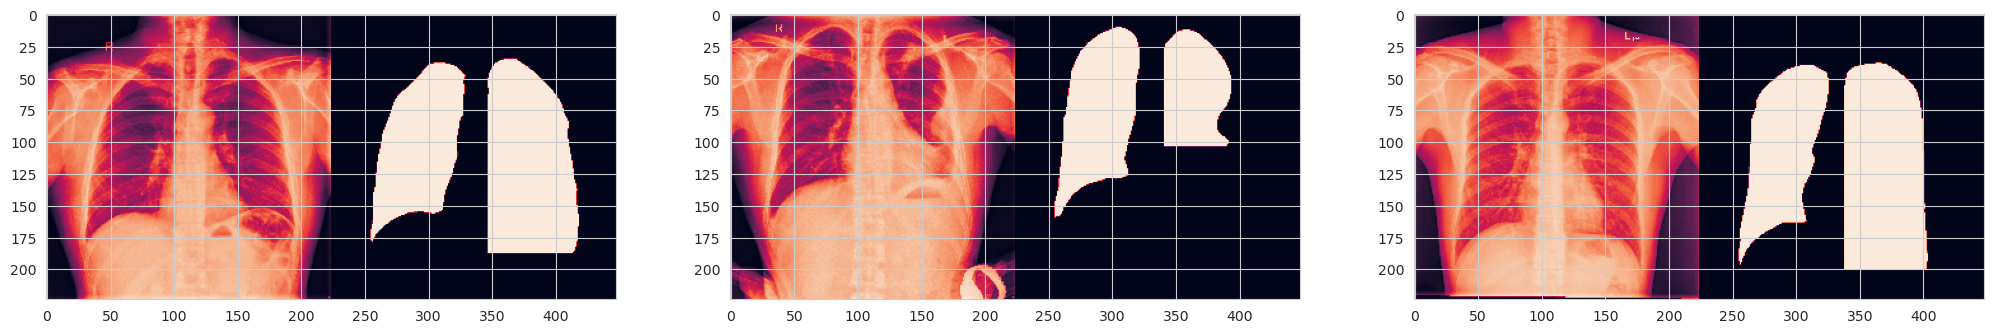

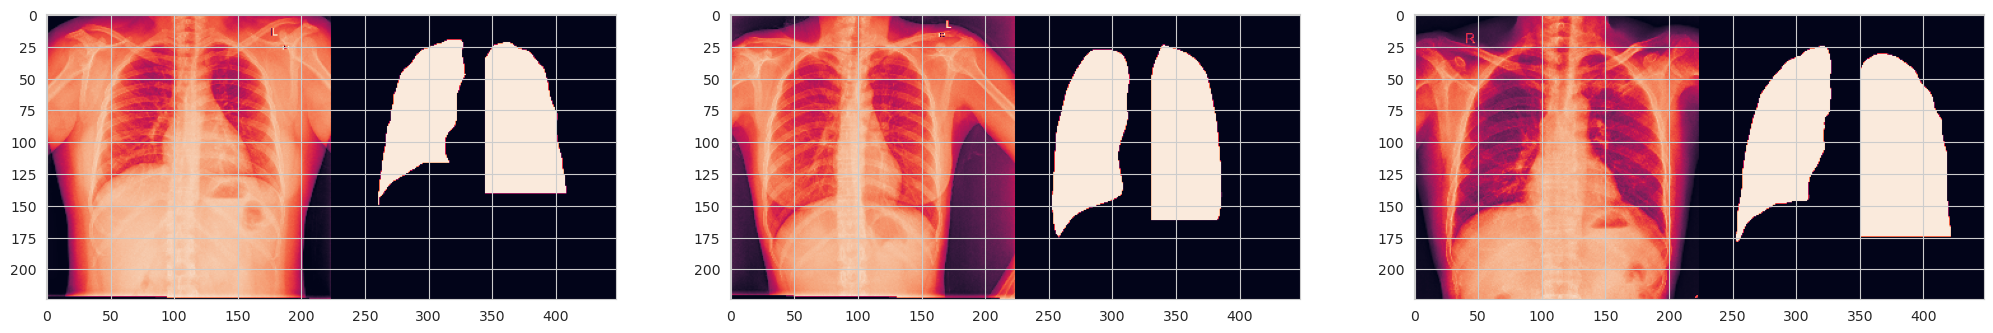

Данные Монтгомери


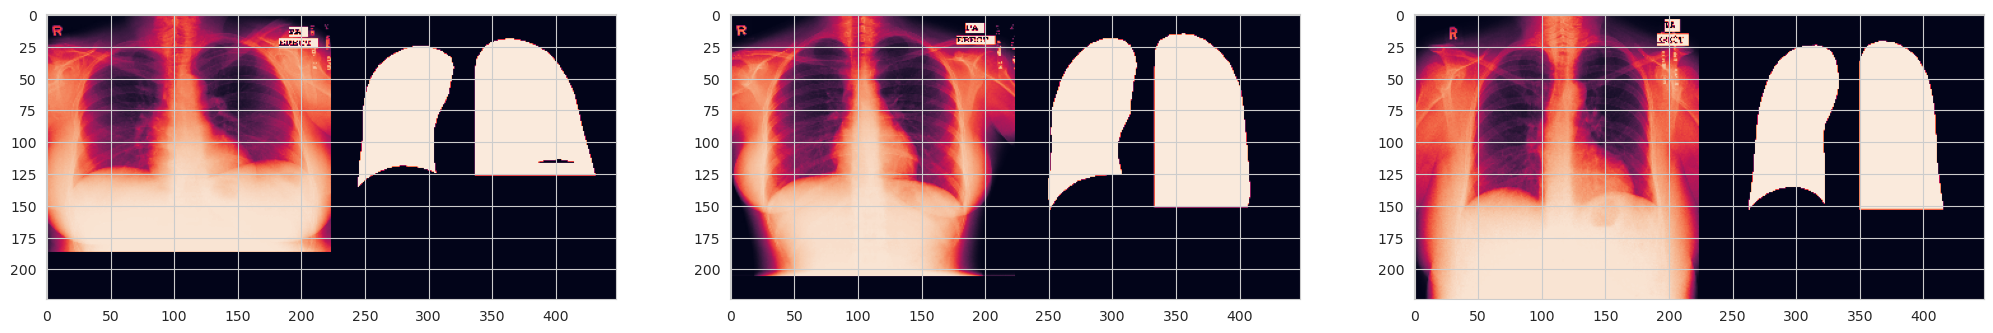

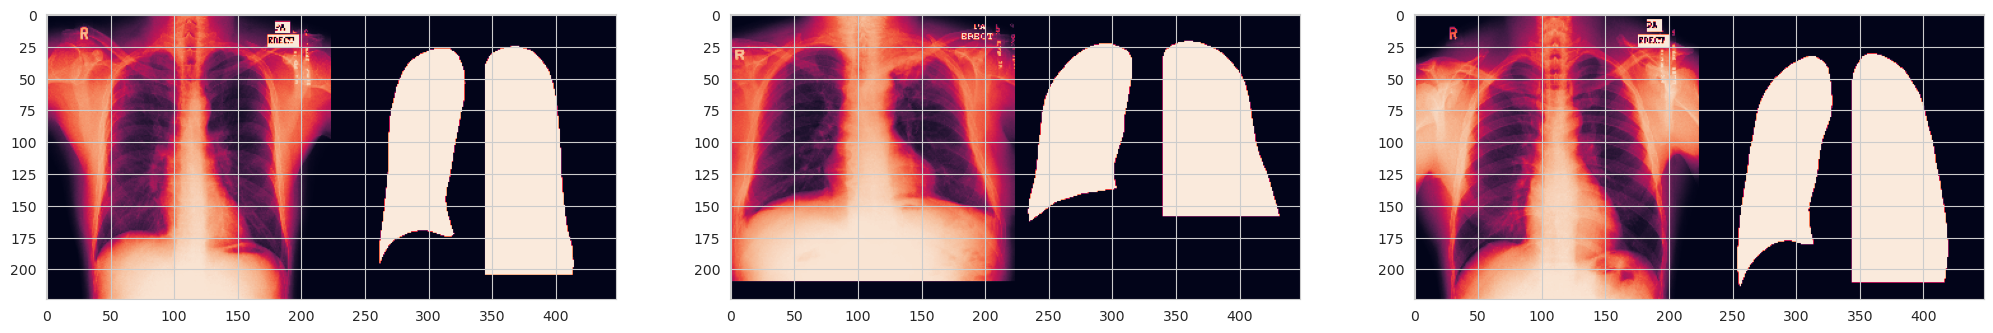

Данные JSRT


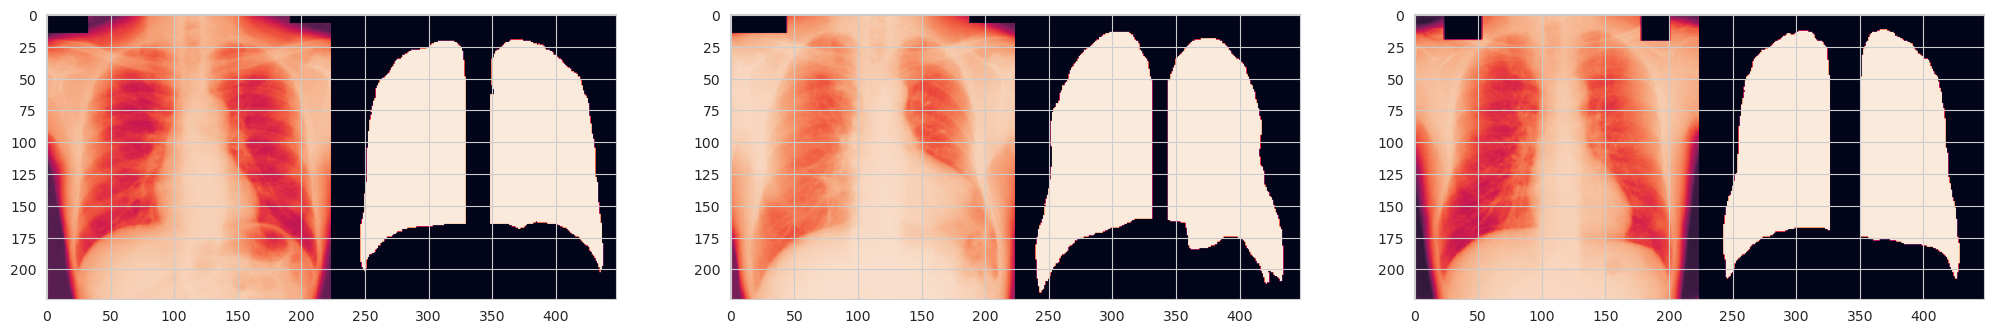

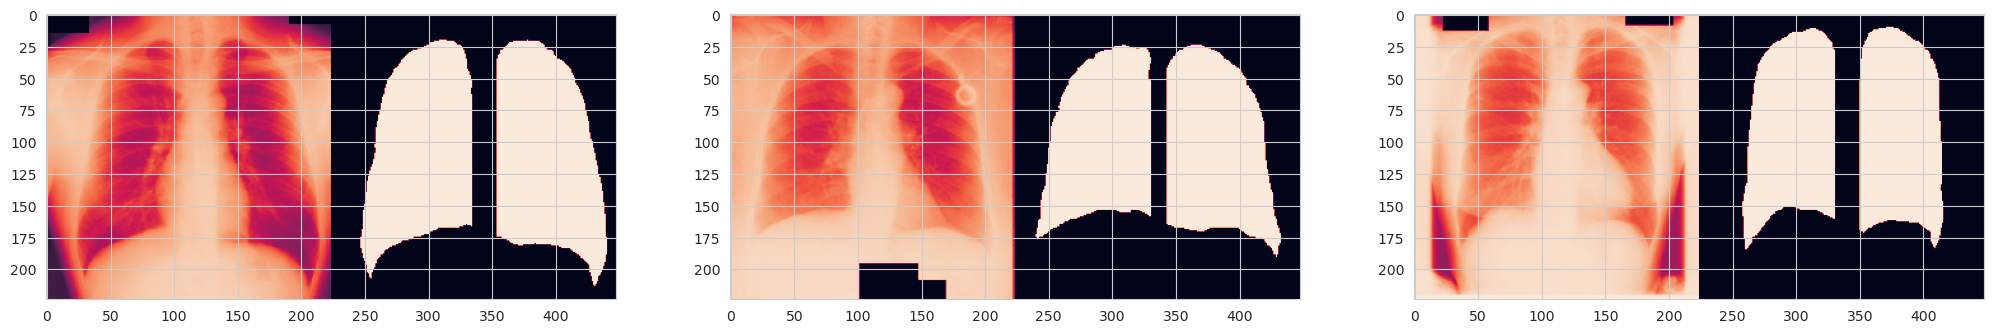

Данные RSNA


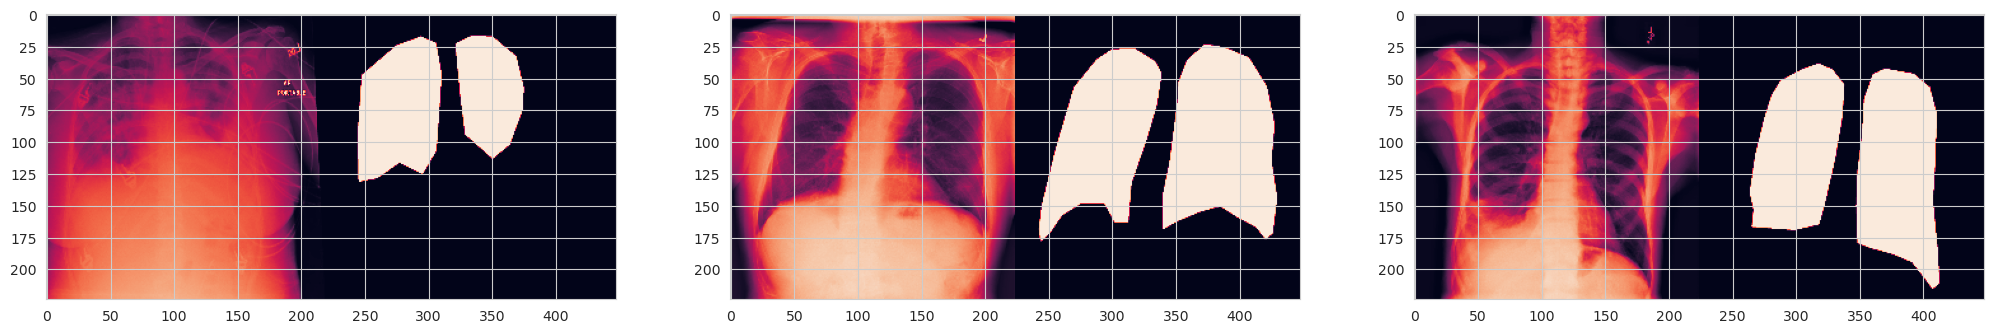

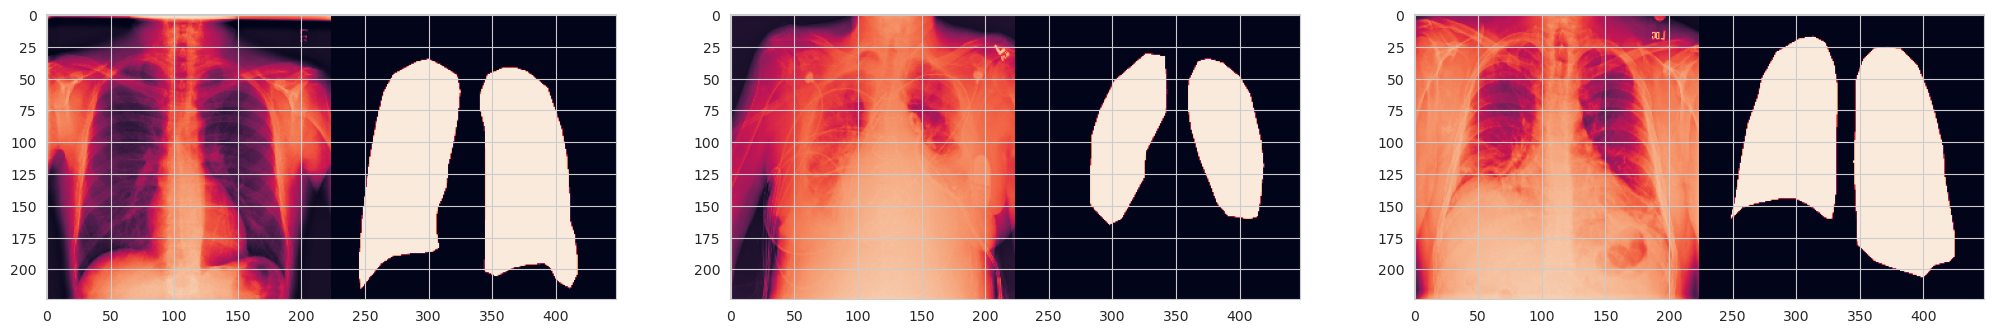

In [14]:
print("Данные Шэньчжэня")
plotMask(CHNCXR_images, CHNCXR_masks)
print("Данные Монтгомери")
plotMask(MCUCXR_images, MCUCXR_masks)
print("Данные JSRT")
plotMask(JSRT_images, JSRT_masks)
print("Данные RSNA")
plotMask(RSNA_images, RSNA_masks)

In [15]:
CHNCXR_images = np.array(CHNCXR_images).reshape(len(CHNCXR_images), IMG_SIZE, IMG_SIZE, 1)
CHNCXR_masks = np.array(CHNCXR_masks).reshape(len(CHNCXR_masks), IMG_SIZE, IMG_SIZE, 1)
MCUCXR_images = np.array(MCUCXR_images).reshape(len(MCUCXR_images), IMG_SIZE, IMG_SIZE, 1)
MCUCXR_masks = np.array(MCUCXR_masks).reshape(len(MCUCXR_masks), IMG_SIZE, IMG_SIZE, 1)
JSRT_images = np.array(JSRT_images).reshape(len(JSRT_images), IMG_SIZE, IMG_SIZE, 1)
JSRT_masks = np.array(JSRT_masks).reshape(len(JSRT_masks), IMG_SIZE, IMG_SIZE, 1)
RSNA_images = np.array(RSNA_images).reshape(len(RSNA_images), IMG_SIZE, IMG_SIZE, 1)
RSNA_masks = np.array(RSNA_masks).reshape(len(RSNA_masks), IMG_SIZE, IMG_SIZE, 1)

In [16]:
assert CHNCXR_images.shape == CHNCXR_masks.shape
assert MCUCXR_images.shape == MCUCXR_masks.shape
assert JSRT_images.shape == JSRT_masks.shape
assert RSNA_images.shape == RSNA_masks.shape

In [17]:
images = np.concatenate((CHNCXR_images, MCUCXR_images, JSRT_images, RSNA_images),axis=0)
masks = np.concatenate((CHNCXR_masks, MCUCXR_masks, JSRT_masks, RSNA_masks),axis=0)

In [18]:
print(images.shape)
print(masks.shape)

(1951, 224, 224, 1)
(1951, 224, 224, 1)


# Обучение модели

In [19]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [20]:
def Unet(input_size=(224, 224, 1)):
    inputs = Input(input_size)
    
    # Сжимающий путь
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Центральный блок
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Расширяющий путь
    up6 = UpSampling2D(size=(2,2))(conv5)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2,2))(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2,2))(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = UpSampling2D(size=(2,2))(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    return model

In [21]:
model = Unet(input_size=(IMG_SIZE, IMG_SIZE, 1))
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])

2024-08-27 22:51:24.499569: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 22:51:24.597967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 22:51:24.598222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [22]:
name = 'Segmentation-Unet-224.keras'

rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 1, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)     
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')    
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-5, patience = 3, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]

In [23]:
train_images, val_images, train_seg, val_seg = train_test_split(images.astype('float32') / 255.0,
                                                                masks.astype('float32') / 255.0,
                                                                test_size=0.2,
                                                                random_state=SEED)

In [24]:
print(train_images.shape, val_images.shape, train_seg.shape, val_seg.shape)

(1560, 224, 224, 1) (391, 224, 224, 1) (1560, 224, 224, 1) (391, 224, 224, 1)


In [25]:
loss_history = model.fit(x=train_images,
                         y=train_seg,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(val_images, val_seg),
                         callbacks=callbacks_list)

Epoch 1/100


I0000 00:00:1724774137.805352   17484 service.cc:145] XLA service 0x7f34c403afd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724774137.805384   17484 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-27 22:55:38.043981: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 22:55:38.895467: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-08-27 22:55:43.477874: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-27 22:55:43.659109: W external/local_tsl/tsl/framework/bfc_allocator.cc:296]

   3/1560 ━━━━━━━━━━━━━━━━━━━━ 1:09 44ms/step - binary_accuracy: 0.5067 - dice_coef: 0.4375 - loss: -0.4375  

I0000 00:00:1724774147.532053   17484 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1559/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8934 - dice_coef: 0.8376 - loss: -0.8376
Epoch 1: val_loss improved from inf to -0.79838, saving model to Segmentation-Unet-224.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 89s 46ms/step - binary_accuracy: 0.8934 - dice_coef: 0.8377 - loss: -0.8377 - val_binary_accuracy: 0.8969 - val_dice_coef: 0.7984 - val_loss: -0.7984 - learning_rate: 0.0100
Epoch 2/100
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.9468 - dice_coef: 0.9146 - loss: -0.9146
Epoch 2: val_loss improved from -0.79838 to -0.82602, saving model to Segmentation-Unet-224.keras
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - binary_accuracy: 0.9468 - dice_coef: 0.9146 - loss: -0.9146 - val_binary_accuracy: 0.9116 - val_dice_coef: 0.8260 - val_loss: -0.8260 - learning_rate: 0.0100
Epoch 3/100
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.9530 - dice_coef: 0.9245 - loss: -0.9245
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00

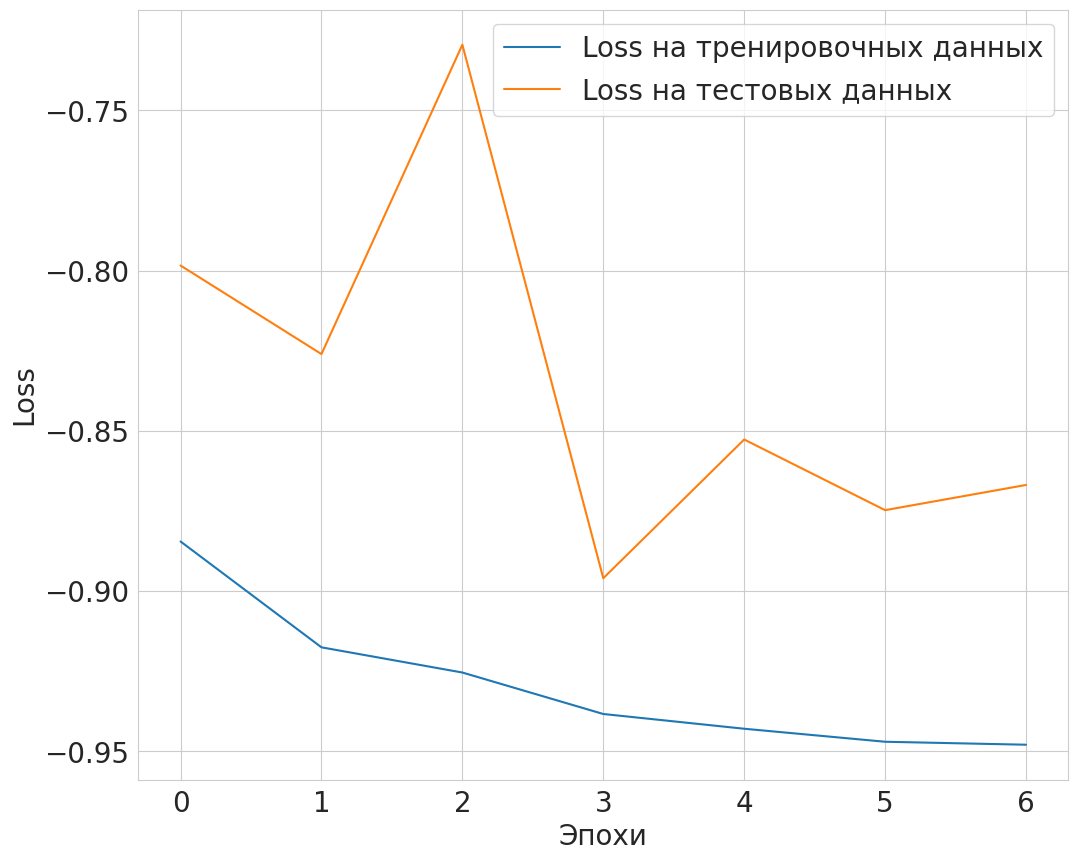

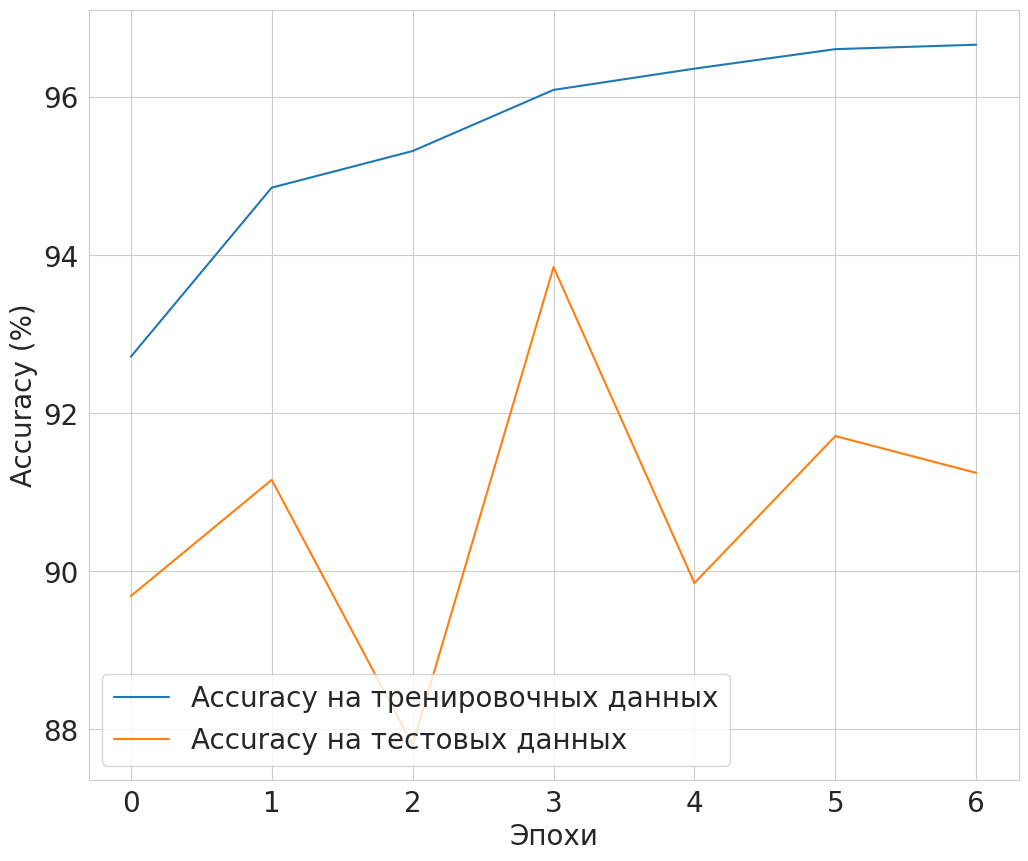

In [27]:
fig1, ax1 = plt.subplots(figsize = (12, 10))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss на тренировочных данных')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Loss на тестовых данных')
ax1.set_xlabel('Эпохи', fontsize=20)
ax1.set_ylabel('Loss', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(fontsize=20)
plt.show()

fig2, ax2 = plt.subplots(figsize = (12, 10))
ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy на тренировочных данных')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Accuracy на тестовых данных')
ax2.set_xlabel('Эпохи', fontsize=20)
ax2.set_ylabel('Accuracy (%)', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.legend(fontsize=20)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


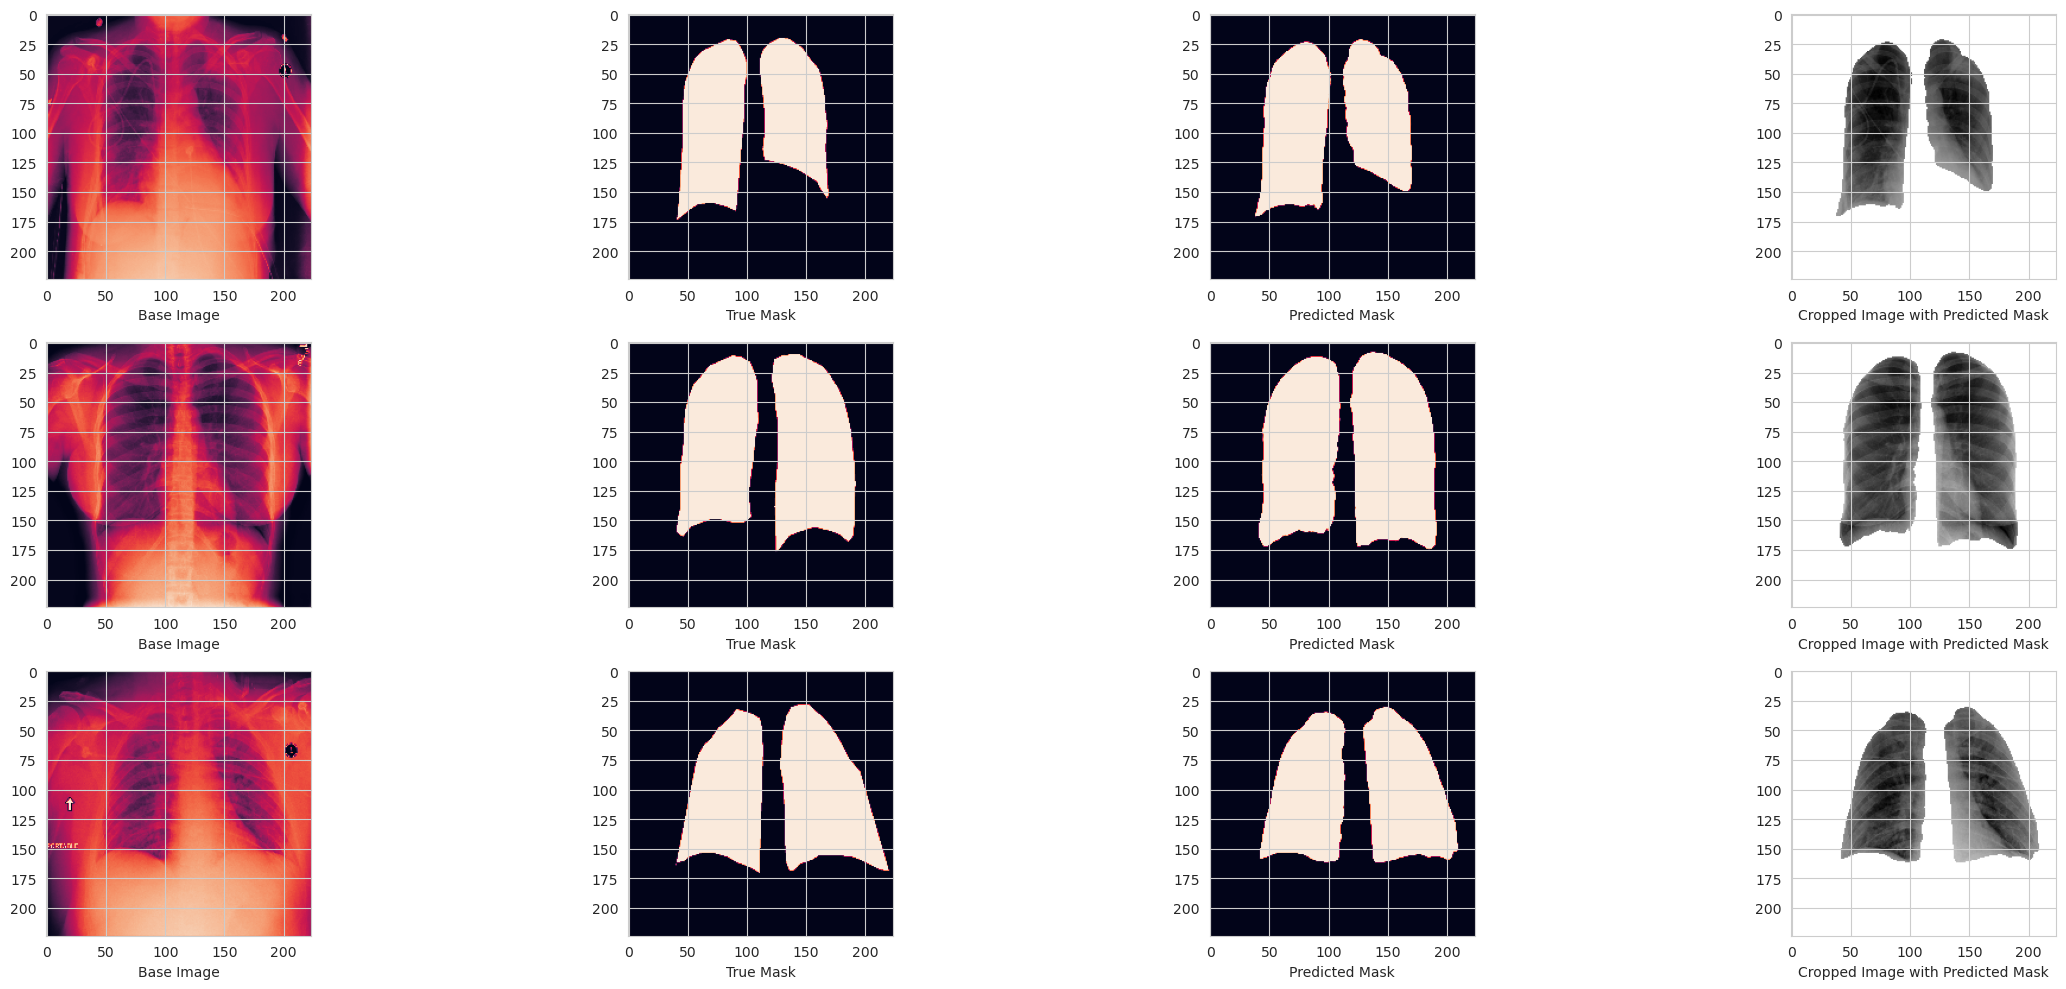

In [28]:
first_three_preds = model.predict(val_images[:3], verbose=1)

plt.figure(figsize=(25, 10))
for i in range(3):
    plt.subplot(3, 4, 4*i + 1)
    plt.imshow(np.squeeze(val_images[i]))
    plt.xlabel("Base Image")

    plt.subplot(3, 4, 4*i + 2)
    plt.imshow(np.squeeze(val_seg[i]))
    plt.xlabel("True Mask")

    plt.subplot(3, 4, 4*i + 3)
    plt.imshow(np.squeeze(first_three_preds[i]))
    plt.xlabel("Predicted Mask")

    masked_image = np.copy(np.squeeze(val_images[i]))
    binary_mask = np.squeeze(first_three_preds[i]) >= 0.5
    masked_image[~binary_mask] = 0  
    background_color = 1  
    masked_image[~binary_mask] = background_color  

    plt.subplot(3, 4, 4*i + 4)
    plt.imshow(masked_image, cmap='gray') 
    plt.xlabel("Cropped Image with Predicted Mask")

plt.tight_layout()
plt.show()

# Обучение модели на всех данных

In [29]:
name = 'Segmentation-Unet-224-full.keras'

rlr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, verbose=1, min_delta=1e-4, min_lr=1e-7, mode='min', cooldown=1)
ckp = ModelCheckpoint(name, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [rlr, ckp]

loss_history = model.fit(x=images.astype('float32') / 255.0,
                         y=masks.astype('float32') / 255.0,
                         batch_size=BATCH_SIZE,
                         epochs=6,
                         callbacks=callbacks_list)

Epoch 1/6
1950/1951 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.9633 - dice_coef: 0.9422 - loss: -0.9422
Epoch 1: loss improved from inf to -0.94246, saving model to Segmentation-Unet-224-full.keras
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - binary_accuracy: 0.9633 - dice_coef: 0.9422 - loss: -0.9422 - learning_rate: 1.0000e-06
Epoch 2/6
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.9630 - dice_coef: 0.9422 - loss: -0.9422
Epoch 2: loss improved from -0.94246 to -0.94257, saving model to Segmentation-Unet-224-full.keras
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 86s 44ms/step - binary_accuracy: 0.9630 - dice_coef: 0.9422 - loss: -0.9422 - learning_rate: 1.0000e-06
Epoch 3/6
1951/1951 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - binary_accuracy: 0.9628 - dice_coef: 0.9425 - loss: -0.9425
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 3: loss improved from -0.94257 to -0.94266, saving model to Segmentation-Unet-224-full.keras
1951/1951 ━━━━━━━━━━━━━━━━━━━